In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm.auto import tqdm
from sklearn.manifold import MDS

import multitask.dataset as dataset
from multitask.models.task_switching import get_task_model
import multitask.models.task_switching.hooks as hooks
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs
from multitask.representations import get_mean_activations, calculate_rdm, plot_rdm

In [2]:
plt.style.use('../style/plots.mplstyle')
palette = ['#c0d9ffff', '#bfc1ffff', '#e3bfffff', '#ffbfe6ff', '#ffbfc4ff']

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure = os.path.join('svg', 'figureS13_mds_contexts_all.svg')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
idxs_contexts = list(range(len(num_hidden)))

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-28_02_23_14)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [7]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1
    assert task_switching_tasks[task_name]['activations'][i_context] is not None, 'Set the value for all, first or removed!'

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0]
value: [0, 1]


In [9]:
device = get_device()
criterion = nn.CrossEntropyLoss()

seeds_task_swithing  = sorted(list(results_task_switching.keys()))
list_activations = []
list_numbers = []
list_rdm = []

for i_seed, seed in tqdm(enumerate(seeds_task_swithing), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    _, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)

    mean_activations = get_mean_activations(activations,
                                            num_hidden,
                                            list_labels=numbers,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                             tasks_names=tasks_names)
    
    
    list_activations.append(activations)
    list_numbers.append(numbers)
    list_rdm.append(rdm_dict)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

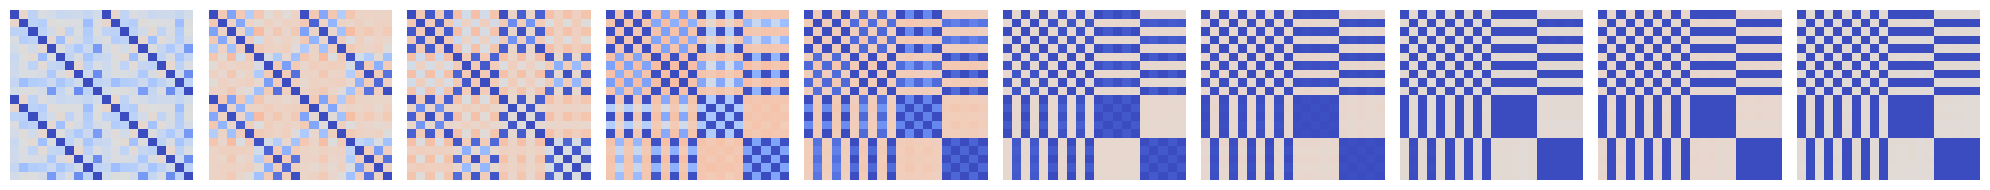

In [10]:
mean_rdm = {}
num_layers = len(num_hidden)

for layer in range(num_layers):
    mean_rdm[layer+1] = np.zeros_like(list_rdm[0][layer+1])
    for rdm in list_rdm:
        mean_rdm[layer+1] += rdm[layer+1]
    mean_rdm[layer+1] /= num_runs

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_rdm(ax, mean_rdm, num_hidden, cmap='coolwarm', vmin=0, vmax=2)
fig.tight_layout()
plt.show()

/Users/sgalella/miniconda3/envs/multitask/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/sgalella/miniconda3/envs/multitask/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/sgalella/miniconda3/envs/multitask/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/sgalella/miniconda3/envs/multitask/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `norma

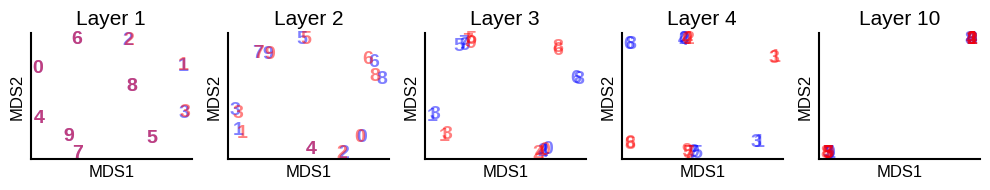

In [15]:
idxs_layers = [0, 1, 2, 3, 9]  # Layers to show in the plots
num_layers_plot = len(idxs_layers)

fig, ax = plt.subplots(1, num_layers_plot, figsize=(2 * num_layers_plot, 2))

for i_layer, idx_layer in enumerate(idxs_layers):
    num_units = num_hidden[idx_layer]
    layer = f'layer{idx_layer+1}'

    mds_2dim = MDS(n_components=2,
               metric=True,
               dissimilarity='precomputed',
               random_state=4321,
               max_iter=1000,
               n_init=20,
               eps=1e-5)
    mds_activations = mds_2dim.fit_transform(mean_rdm[idx_layer+1])

    mds_parity = mds_activations[:10, :]
    mds_value = mds_activations[10:, :]
    
    ax[i_layer].scatter(mds_activations[:, 0], mds_activations[:, 1], alpha=0)

    for number in range(10):
        ax[i_layer].text(mds_parity[number, 0], mds_parity[number, 1], number, ha='center', va='center', color='blue', fontsize=14, weight='bold', alpha=0.5)

    for number in range(10):
        ax[i_layer].text(mds_value[number, 0], mds_value[number, 1], number, ha='center', va='center', color='red', fontsize=14, weight='bold', alpha=0.5)

    ax[i_layer].set_xlabel('MDS1', fontsize=12)
    ax[i_layer].set_ylabel('MDS2', fontsize=12)
    ax[i_layer].set_title(f'Layer {idx_layer + 1}', fontsize=15)

    ax[i_layer].set_xticks([])
    ax[i_layer].set_yticks([])

fig.tight_layout()
fig.savefig(path_figure)  # Add sum to distinguish Removed
plt.show()